In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
# import torch.utils.data
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import datasets

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Download dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
def save_to_drive(model, optimizer, epoch, loss, project_name):
    dir = "drive/MyDrive/trained_models/" + project_name
    if not os.path.exists(dir):
        os.makedirs(dir)

    path = dir + '/model.ph'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

In [4]:
!pip install kaggle

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [6]:
!kaggle datasets download -d huanghanchina/pascal-voc-2012

pascal-voc-2012.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -n pascal-voc-2012.zip -d ./

Archive:  pascal-voc-2012.zip


## Preproces

In [8]:
IMAGE_DIR = './VOC2012/JPEGImages'
ANNOTATIONS_DIR = './VOC2012/Annotations'
LABEL_DIR = './VOC2012/Labels'

ANNOTATIONS = [f.split('.')[0] for f in os.listdir(ANNOTATIONS_DIR)]
ANNOTATIONS[:20]

['2012_002150',
 '2010_002420',
 '2008_003913',
 '2011_005732',
 '2011_003418',
 '2008_007565',
 '2008_000422',
 '2011_006513',
 '2007_009817',
 '2010_005098',
 '2010_005949',
 '2011_006585',
 '2009_004562',
 '2009_004579',
 '2008_007893',
 '2011_005758',
 '2008_008469',
 '2010_000244',
 '2011_004280',
 '2008_007219']

In [9]:
!mkdir -p VOC2012/Labels

In [10]:
import xml.etree.ElementTree as ET

def convert(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x *= dw
    w *= dw
    y *= dh
    h *= dh 
    return (x, y, w, h)

def convert_labels(annotations_path, label_path, annotations):
    classes = []
    for a in annotations:
        in_file = open(annotations_path + '/' + a + '.xml')
        out_file = open(label_path + '/' + a + '.txt', 'w')

        tree = ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        
        for obj in root.iter('object'):
            cls = obj.find('name').text

            if cls not in classes:
                classes.append(cls)

            cls_idx = classes.index(cls)
            box = obj.find('bndbox')
            b = (float(box.find('xmin').text),
                 float(box.find('xmax').text),
                 float(box.find('ymin').text),
                 float(box.find('ymax').text))
            
            bbox = convert((w, h), b)
            out_file.write(str(cls_idx) + " " + 
                           " ".join([str(bb) for bb in bbox]) + '\n')

        in_file.close()
        out_file.close()
    return classes

CLASS_INDICES = convert_labels(ANNOTATIONS_DIR, LABEL_DIR, ANNOTATIONS)
CLASS_INDICES

['person',
 'train',
 'boat',
 'motorbike',
 'bird',
 'sheep',
 'car',
 'chair',
 'pottedplant',
 'diningtable',
 'bottle',
 'bus',
 'cat',
 'tvmonitor',
 'sofa',
 'bicycle',
 'aeroplane',
 'horse',
 'dog',
 'cow']

## Consts

In [11]:
!pip install --upgrade albumentations

In [12]:
import albumentations as A
import cv2

from albumentations.pytorch import ToTensorV2

BATCH_SIZE = 32
IMAGE_SIZE = 416
NUM_CLASSES = 20
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 100
CONF_THRESHOLD = 0.05
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

###############
#
# B : (conolutional_block, out_channels, kernel_size, stride)
# R : (residual_bloc, num_blocks)
# U : (upsample)
# P : (prediction)
#
###############

config = [
    ('B', 32, 3, 1),
    ('B', 64, 3, 2),
    ('R', 1),
    ('B', 128, 3, 2),
    ('R', 2),
    ('B', 256, 3, 2),
    ('R', 8),
    ('B', 512, 3, 2),
    ('R', 8),
    ('B', 1024, 3, 2),
    ('R', 4),
    ('B', 512, 1, 1),
    ('B', 1024, 3, 1),
    ('P'),
    ('B', 256, 1, 1),
    ('U'),
    ('B', 256, 1, 1),
    ('B', 512, 3, 1),
    ('P'),
    ('B', 128, 1, 1),
    ('U'),
    ('B', 128, 1, 1),
    ('B', 256, 3, 1),
    ('P'),
]

# TO DO: Implement transforms
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * 1.1)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * 1.1),
            min_width=int(IMAGE_SIZE * 1.1),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, 
                    saturation=0.6, hue=0.6, p=0.4),
        A.ShiftScaleRotate(
            rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
        )
        ,
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='yolo',
                             min_visibility=0.4, 
                             label_fields=[]),
)

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE)), 
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE),
            min_width=int(IMAGE_SIZE),
            border_mode=cv2.BORDER_CONSTANT,
        ),  
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),           
    ],
    bbox_params=A.BboxParams(format='yolo',
                             min_visibility=0.4, 
                             label_fields=[]),
)

## Helpers

In [13]:
def iou(box1, box2):
    """
    Returns interection over union (using w and h)
    """

    intersection = (torch.min(box1[..., 0], box2[..., 0]) *
                  torch.min(box1[..., 1], box2[..., 1]))

    union = (box1[..., 0] * box1[..., 1] +
            box2[..., 0] * box2[..., 1] -
            intersection)

    return intersection / (union + 1e-5)

In [14]:
import math

def intersection_over_union(box_pred, box_true, ciou=False):
    """
    Returns intersection over union for real bboxes.
    """

    box1_x1 = box_pred[..., 0:1] - box_pred[..., 2:3] / 2
    box1_y1 = box_pred[..., 1:2] - box_pred[..., 3:4] / 2
    box1_x2 = box_pred[..., 0:1] + box_pred[..., 2:3] / 2
    box1_y2 = box_pred[..., 1:2] + box_pred[..., 3:4] / 2
    box2_x1 = box_true[..., 0:1] - box_true[..., 2:3] / 2
    box2_y1 = box_true[..., 1:2] - box_true[..., 3:4] / 2
    box2_x2 = box_true[..., 0:1] + box_true[..., 2:3] / 2
    box2_y2 = box_true[..., 1:2] + box_true[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

    # b1_x1 = box_pred[..., 0:1] - box_pred[..., 2:3] / 2
    # b1_y1 = box_pred[..., 1:2] - box_pred[..., 3:4] / 2
    # b1_x2 = box_pred[..., 0:1] + box_pred[..., 2:3] / 2
    # b1_y2 = box_pred[..., 1:2] + box_pred[..., 3:4] / 2

    # b2_x1 = box_true[..., 0:1] - box_true[..., 2:3] / 2
    # b2_y1 = box_true[..., 1:2] - box_true[..., 3:4] / 2
    # b2_x2 = box_true[..., 0:1] + box_true[..., 2:3] / 2
    # b2_y2 = box_true[..., 1:2] + box_true[..., 3:4] / 2

    # x1 = torch.max(b1_x1, b2_x1)
    # y1 = torch.max(b1_y1, b2_y1)
    # x2 = torch.max(b1_x2, b2_x2)
    # y2 = torch.max(b1_y2, b1_y2)

    # intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    # if torch.sum(torch.isnan(intersection)) > 0:
    #     intersection = torch.nan_to_num(intersection, nan=intersection.maximum())
    # box1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    # box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    # union = box1_area + box2_area - intersection + 1e-6

    # ious = intersection / union


    # if torch.sum(torch.isnan(ious)) > 0:
    #     ious = torch.nan_to_num(ious)

    # if torch.sum(torch.isnan(iou)) > 0:
    #     print(x1)
    #     print(x2)
    #     print(y1)
    #     print(y2)
    #     iou = torch.nan_to_num(iou)
    
    # if ciou:
    #     cw = torch.max(bbox1[2], bbox2[2]) - torch.min(bbox1[0], bbox2[0])
    #     ch = torch.max(bbox1[3], bbox2[3]) - torch.min(bbox1[3], bbox2[3])

    #     c2 = cw**2 + ch**2 +1e-5
    #     rho2 = ((bbox2[0] + bbox2[2] - bbox1[0] - bbox1[2])**2 + 
    #             (bbox2[1] + bbox2[3] - bbox1[1] - bbox1[3])**2)/4
    #     v = (4 / math.pi**2) * (torch.pow(
    #         torch.atan((bbox2[2] - bbox2[0])/(bbox2[3] - bbox2[1] + 1e-5)) - 
    #         torch.atan((bbox1[2] - bbox1[0])/(bbox1[3] - bbox1[1] + 1e-5)), 2))
    #     alpha = v / ((1+1e-5) - iou + v)
    #     iou = iou - (rho2/c2 + v*alpha)
    #     if torch.sum(torch.isnan(iou)) > 0:
    #         iou = torch.nan_to_num(iou)
    #     return iou
    # return ious

## Dataset loader

In [15]:
class CustomDataset(Dataset):
    def __init__(self, annotations, image_dir, label_dir, anchors, image_size=416,
                 S=[13, 26, 52], C=20, transforms=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transforms = transforms
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = torch.div(self.num_anchors, 3, rounding_mode='floor')
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations[index] + '.txt')
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=' ', ndmin=2),
                         4, axis=1).tolist()
        img_path = os.path.join(self.image_dir, self.annotations[index] + '.jpg')
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transforms:
            augments = self.transforms(image=image, bboxes=bboxes)
            image = augments['image']
            bboxes = augments['bboxes']

        targets = [torch.zeros((torch.div(self.num_anchors, 3, rounding_mode='floor'), S, S, 6)) for S in self.S]

        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, w, h, c = box
            has_anchor = [False] * 3

            for anchor_idx in anchor_indices:
                scale_idx = torch.div(anchor_idx, self.num_anchors_per_scale, rounding_mode='floor')
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_c, y_c = S * x - j, S * y - i
                    w_c, h_c = (w * S, h * S)
                    box_coordinates = torch.tensor([x_c, y_c, w_c, h_c])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(c)
                    has_anchor[scale_idx] = True
                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1

        return image, tuple(targets)
# TO DO: Test dataloader

## Train function

In [16]:
def get_accuracy(true, pred, device):
    """
    Returns: class accuracy, object accuracy, no object accuracy
    """

    total_c, correct_c = 0, 0
    total_n, correct_n = 0, 0
    total_o, correct_o = 0, 0

    for i in range(3):
        true[i] = true[i].to(device)
        obj = true[i][..., 0] == 1
        noobj = true[i][..., 0] == 0
        correct_c += torch.sum(
                torch.argmax(pred[i][..., 5][obj], dim=-1) == true[i][..., 5][obj]
            )
        total_c += torch.sum(obj)

        obj_preds = torch.sigmoid(pred[i][..., 0]) > CONF_THRESHOLD
        correct_o += torch.sum(obj_preds[obj] == true[i][..., 0][obj])
        total_o += torch.sum(obj)
        correct_n += torch.sum(obj_preds[noobj] == true[i][..., 0][noobj])
        total_n += torch.sum(noobj)

    acc_c = correct_c / total_c * 100
    acc_o = correct_o / total_o * 100
    acc_n = correct_n / total_n * 100

    return acc_c.item(), acc_o.item(), acc_n.item()


In [17]:
from tqdm import tqdm

def train_step(model, train_loader, optimizer, loss, scaled_anchors, scaler, device='cuda'):
    tq = tqdm(train_loader, leave=True, desc="Train")
    losses = []
    accuracy = []

    model.train()

    for i, (data, target) in enumerate(tq):
        data = data.to(device)
        t0, t1, t2 = target[0].to(device), target[1].to(device), target[2].to(device)

        with torch.cuda.amp.autocast():
            out = model(data)

            l = (loss(out[0], t0, scaled_anchors[0]) +
                 loss(out[1], t1, scaled_anchors[1]) +
                 loss(out[2], t2, scaled_anchors[2]))

        losses.append(l.item())
        optimizer.zero_grad()
        scaler.scale(l).backward()
        scaler.step(optimizer)
        scaler.update()
        l.detach()

        mean_loss = sum(losses) / len(losses)
        tq.set_postfix(loss=mean_loss)

        acc = get_accuracy(target, out, device)
        accuracy.append(acc)

    mean_loss = sum(losses) / len(losses)
    avg_acc = np.array(accuracy).mean(axis=0)
    return mean_loss, avg_acc

In [18]:
def val(model, val_loader, optimizer, loss, scaled_anchors, scaler, device='cuda'):
    tq = tqdm(val_loader, leave=True, desc="Val")
    losses = []
    accuracy = []

    model.eval()

    with torch.no_grad():
        for i, (data, target) in enumerate(tq):
            data = data.to(device)
            t0, t1, t2 = target[0].to(device), target[1].to(device), target[2].to(device)
            out = model(data)

            l = (loss(out[0], t0, scaled_anchors[0]) +
                 loss(out[1], t1, scaled_anchors[1]) +
                 loss(out[2], t2, scaled_anchors[2]))

            losses.append(l.detach().item())

            mean_loss = sum(losses) / len(losses)
            tq.set_postfix(loss=mean_loss)

            acc = get_accuracy(target, out, device)
            accuracy.append(acc)

    mean_loss = sum(losses) / len(losses)
    avg_acc = np.array(accuracy).mean(axis=0)
    return mean_loss, avg_acc

In [19]:
def test(model, test_loader, optimizer, loss, scaled_anchors, scaler, device='cuda'):
    tq = tqdm(test_loader, leave=True, desc="Test")
    losses = []
    accuracy = []

    model.eval()

    with torch.no_grad():
        for i, (data, target) in enumerate(tq):
            data = data.to(device)
            t0, t1, t2 = target[0].to(device), target[1].to(device), target[2].to(device)
            out = model(data)

            l = (loss(out[0], t0, scaled_anchors[0]) +
                 loss(out[1], t1, scaled_anchors[1]) +
                 loss(out[2], t2, scaled_anchors[2]))

            losses.append(l.detach().item())

            mean_loss = sum(losses) / len(losses)
            tq.set_postfix(loss=mean_loss)

            acc = get_accuracy(target, out, device)
            accuracy.append(acc)

    mean_loss = sum(losses) / len(losses)
    avg_acc = np.array(accuracy).mean(axis=0)
    return mean_loss, avg_acc

In [20]:
def train(model, train_loader, val_loader, test_loader, optimizer, 
          loss, anchors, S, start_epoch, epochs, best_loss, name="test_name", device='cuda'):
    scaled_anchors = (torch.tensor(anchors) * 
                     torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
    scaled_anchors = scaled_anchors.to(device)

    best_model = model.state_dict()
    scaler = torch.cuda.amp.GradScaler()

    history = {}
    history['train_loss'] = []
    history['train_acc'] = []
    history['val_loss'] = []
    history['val_acc'] = []

    history['test_loss'] = 0
    history['test_acc'] = 0

    for epoch in range(1 + start_epoch, 1+epochs):
        train_loss, train_acc = train_step(model, train_loader, 
                                           optimizer, loss, scaled_anchors,
                                           scaler, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = val(model, val_loader, 
                                optimizer, loss, 
                                scaled_anchors, scaler, device)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if best_loss == best_loss and (best_loss is None or val_loss < best_loss):
            best_model = model.state_dict()
            best_loss = val_loss

            save_to_drive(model, optimizer, epoch, best_loss, name)

    test_loss, test_acc = test(model, test_loader, optimizer, loss, 
                               scaled_anchors, scaler, device)

    history['test_loss'] = test_loss
    history['test_acc'] = test_acc

    model.load_state_dict(best_model)

    return history

## Loss


In [21]:
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
entropy = nn.CrossEntropyLoss()

def Loss(predictions, target, anchors):
    obj = target[..., 0] == 1
    noobj = target[..., 0] == 0 

    no_object_loss = bce(
        (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
    )

    anchors = anchors.reshape(1, 3, 1, 1, 2)
    box_preds = torch.cat([torch.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
    ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
    object_loss = mse(torch.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

    predictions[..., 1:3] = torch.sigmoid(predictions[..., 1:3])
    target[..., 3:5] = torch.log(
        (1e-16 + target[..., 3:5] / anchors)
    )
    box_loss = mse(predictions[..., 1:5][obj], target[..., 1:5][obj])


    class_loss = entropy(
        (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
    )

    return (10 * box_loss + 1 * object_loss + 10 * no_object_loss + 1 * class_loss)
    # obj = target[..., 0] == 1
    # noobj = target[..., 0] == 0

    # # No object loss
    # no_obj_loss = bce(
    #         predictions[..., 0:1][noobj],
    #         target[..., 0:1][noobj]
    #     )
    
    # # object loss
    # # obj_loss = bce(
    # #         predictions[..., 0:1][obj],
    # #         target[..., 0:1][obj]
    # #     )
    

    # # bbox loss
    # anchors = anchors.reshape(1, 3, 1, 1, 2)
    # box_pred = torch.cat([
    #     torch.sigmoid(predictions[..., 1:3]),
    #     torch.exp(predictions[..., 3:5]) * anchors
    # ], dim=-1)
    # ious = intersection_over_union(box_pred[obj], target[..., 1:5][obj], True).detach()
    # obj_loss = mse(torch.sigmoid(predictions[..., 0:1][obj]),
    #                                  ious*target[..., 0:1][obj])
    # # bbox_loss = (1-ious).mean()

    # predictions[..., 1:3] = torch.sigmoid(predictions[..., 1:3])
    # target[..., 3:5] = torch.log(1e-16 + target[..., 3:5] / anchors)
    # bbox_loss = mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

    # # class loss
    # class_loss = entropy(predictions[..., 5:][obj], target[..., 5][obj].long())

    # loss = 1.0 * bbox_loss + 2.0 * obj_loss + 1.0 * class_loss + 0.5 * no_obj_loss

    # if loss.item() > 50:
    #     print('--------------------')
    #     print(bbox_loss, bbox_loss*0.05)
    #     print(obj_loss)
    #     print(no_obj_loss)
    #     print(class_loss, class_loss*0.05)

    # return loss



In [22]:
def Loss2(predictions, target, anchors):
    pass

## Model

In [23]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, act=True, **kwargs):
        super().__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels, out_channels, bias=not batch, **kwargs))

        if batch:
            layers.append(nn.BatchNorm2d(out_channels))
        if act:
            layers.append(nn.LeakyReLU(0.1, inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, num_blocks, res=True):
        super().__init__()
        self.layers = nn.ModuleList()
        self.num_blocks = num_blocks

        for _ in range(num_blocks):
            self.layers.append(
                nn.Sequential(
                    CNNBlock(channels, torch.div(channels, 2, rounding_mode='floor'), kernel_size=1),
                    CNNBlock(torch.div(channels, 2, rounding_mode='floor'), channels, kernel_size=3, padding=1)
                )
            )
        self.res = res
    
    def forward(self, x):
        for layer in self.layers:
            if self.res:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

In [25]:
class Predict(nn.Module):
    def __init__(self, in_channels, classes):
        super().__init__()

        self.layer = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (classes+5)*3,  batch=False, act=False, kernel_size=1),
        )
        self.classes = classes

    def forward(self, x):
        x = self.layer(x)
        x = x.reshape(x.shape[0], 3, self.classes+5, x.shape[2], x.shape[3])
        x = x.permute(0, 1, 3, 4, 2)
        return x

In [26]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels, classes):
        super().__init__()

        self.in_channels = in_channels
        self.classes = classes

        self.layers = self._create_model()

    def forward(self, x):
        outs = []
        route_conn = []

        for layer in self.layers:
            if isinstance(layer, Predict):
                outs.append(layer(x))
                continue
            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_blocks == 8:
                route_conn.append(x)
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_conn.pop()], dim=1)

        return outs

    def _create_model(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for element in config:
            if element[0] == 'B':
                _, out_channels, kernel_size, stride = element
                padding = 0
                if kernel_size == 3:
                    padding = 1
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding
                    )
                )
                in_channels = out_channels

            if element[0] == 'R':
                _, blocks = element
                layers.append(ResidualBlock(in_channels, blocks))

            if element[0] == 'U':
                layers.append(nn.Upsample(scale_factor=2),)
                in_channels = in_channels * 3
            
            if element[0] == 'P':
                layers += [
                    ResidualBlock(in_channels, 1, res=False),
                    CNNBlock(in_channels, torch.div(in_channels, 2, rounding_mode='floor'), kernel_size=1),
                    Predict(torch.div(in_channels, 2, rounding_mode='floor'), self.classes)
                ]
                in_channels = torch.div(in_channels, 2, rounding_mode='floor')
        return layers


## Visualisation

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image(images, bboxes):
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, len(CLASS_INDICES))]

    n = int(np.sqrt(len(images)))
    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    plt.subplots_adjust(top=0.95, hspace=0.4)

    for idx, (img, boxes) in enumerate(zip(images, bboxes)):
        image = img.to('cpu').permute(1, 2, 0).numpy()
        h, w, _ = image.shape
        i = idx % n
        j = idx // n

        ax[i][j].imshow(image)

        for box in boxes:
            c = box[0]
            box = box[2:]
            up_l_x = box[0] - box[2] / 2
            up_l_y = box[1] - box[3] / 2
            rect = patches.Rectangle(
                (up_l_x * w, up_l_y * h),
                box[2] * w,
                box[3] * h,
                linewidth=2,
                edgecolor=colors[int(c)],
                facecolor='none'
            )

            ax[i][j].add_patch(rect)
            ax[i][j].text(
                up_l_x * w,
                up_l_y * h,
                s=CLASS_INDICES[int(c)],
                color='white',
                verticalalignment='top',
                bbox={'color': colors[int(c)], 'pad': 0}
            )

    plt.show()


In [28]:
def cells_to_boxes(predict, predicted=True):
    bboxes = []
    anchors = ANCHORS
    anchors = (torch.tensor(anchors) * 
                     torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
    for idx, pred in enumerate(predict):
        bboxes.append(get_box(pred, pred.shape[2], anchors[idx], predicted))
    new_boxes = torch.cat(
        (torch.Tensor(bboxes[0]),
        torch.Tensor(bboxes[1]),
        torch.Tensor(bboxes[2])), dim=1).tolist()
    bboxes = []
    for box in new_boxes:
        bboxes.append(preprocess_boxes(box))
    return bboxes

def preprocess_boxes(bboxes, iou_thresh=NMS_IOU_THRESH, thresh=0.7):
    new_boxes = []
    bboxes = [box for box in bboxes if box[1] > thresh]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    while bboxes:
        chosen = bboxes.pop(0)
        bboxes = [
            box 
            for box in bboxes
            if int(box[0]) != int(chosen[0])
            or intersection_over_union(
                torch.tensor(chosen[2:]), torch.tensor(box[2:])) < iou_thresh
        ]
        new_boxes.append(chosen)
    return new_boxes


def get_box(box, scale, anchors, pred=True):
    num_a = len(anchors)
    preds = box[..., 1:5]
    batch_size = box.shape[0]
    if pred:
        anchors = torch.Tensor(anchors).reshape(1, len(anchors), 1, 1, 2)
        preds[..., 0:2] = torch.sigmoid(preds[..., 0:2])
        preds[..., 2:] = torch.exp(preds[..., 2:]) * anchors
        scores = torch.sigmoid(box[..., 0:1])
        best_class = torch.argmax(box[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = box[..., 0:1]
        best_class = box[..., 5:6]

    cell_indices = torch.arange(scale).repeat(box.shape[0], 3, scale, 1).unsqueeze(-1)
    x = 1.0 / scale * (preds[..., 0:1] + cell_indices)
    y = 1.0 / scale * (preds[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1.0 / scale * preds[..., 2:4]
    new_boxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(batch_size, num_a * scale * scale, 6)
    return new_boxes.tolist()


In [29]:
def display_loss(history):
    ind = list(range(len(history['train_loss'])))
    plt.plot(ind, history['train_loss'], label='line1')
    plt.plot(ind, history['val_loss'], label='line2')
    plt.scatter(ind[-1], history['test_loss'], label='point1')

    plt.legend([
        'train_loss',
        'val_loss',
        'test_loss'
    ])

    plt.ylabel('Loss')
    plt.title('Losses plot')
    plt.show()

In [30]:
def display_acc(history):
    accs_train = np.stack(history['train_acc'], axis=0)
    accs_test = np.stack(history['test_acc'], axis=0)
    accs_val = np.stack(history['val_acc'], axis=0)

    fig, ax = plt.subplots(3)
    plt.subplots_adjust(top=1.2, hspace=0.4)

    labels = ['Class accuracy', 'Object accuracy', 'No object accuracy']

    for i in range(3):
        a_tr = accs_train[:, i]
        a_ts = accs_test[i]
        a_vl = accs_val[:, i]
        ind = list(range(len(a_tr)))
        ax[i].plot(ind, a_tr, label='line1')
        ax[i].plot(ind, a_vl, label='line2')
        ax[i].scatter(ind[-1], a_ts, label='point1')

        ax[i].legend([
            'train_acc',
            'val_acc',
            'test_acc'
        ])

        ax[i].set_ylabel('Accuracy')
        ax[i].set_title(labels[i])
    plt.show()

## Testing model, loader, and other functions

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

yolo = YOLOv3(3, 20).to(device)
summary(yolo, (3, 416, 416))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          CNNBlock-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          CNNBlock-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         CNNBlock-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss = Loss

save_to_drive(model, optimizer, 5, loss, "test yolo")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


In [33]:
test_dataset = CustomDataset(ANNOTATIONS[:8], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
    
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=4)

for data, target in test_loader:
    print(data[2].shape, target[2].shape, len(data))

torch.Size([3, 416, 416]) torch.Size([4, 3, 52, 52, 6]) 4
torch.Size([3, 416, 416]) torch.Size([4, 3, 52, 52, 6]) 4


In [34]:
test_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
    
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)

model.eval()
for data, target in test_loader:
    out = model(data.to(device))
    print(len(out), out[0].shape)
    acc = get_accuracy(target, out, device)
    print(acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


3 torch.Size([1, 3, 13, 13, 25])
(100.0, 100.0, 0.0)
3 torch.Size([1, 3, 13, 13, 25])
(0.0, 100.0, 0.0)


In [35]:
test_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=1)

train_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2)

val_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

history = train(model, train_loader, val_loader, test_loader, optimizer, 
          Loss, ANCHORS, S, 0, 3, None, 'testYolo', device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
Test: 100%|██████████| 2/2 [00:00<00:00, 28.06it/s, loss=65.1]


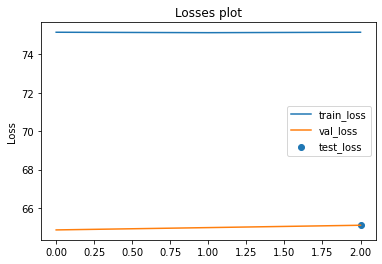

In [36]:
display_loss(history)

In [37]:
history

{'test_acc': array([ 50., 100.,   0.]),
 'test_loss': 65.10641098022461,
 'train_acc': [array([ 50., 100.,   0.]),
  array([ 50., 100.,   0.]),
  array([ 50., 100.,   0.])],
 'train_loss': [75.14118957519531, 75.11871337890625, 75.14118957519531],
 'val_acc': [array([ 50., 100.,   0.]),
  array([ 50., 100.,   0.]),
  array([ 50., 100.,   0.])],
 'val_loss': [64.86376190185547, 64.98413276672363, 65.10641098022461]}

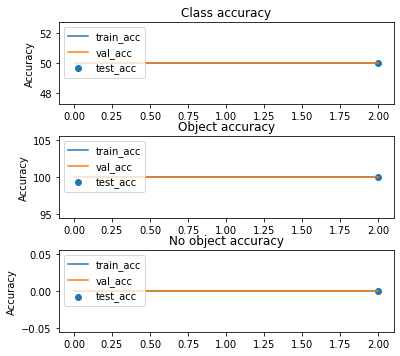

In [38]:
display_acc(history)

In [39]:
test_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=1)

train_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2)

val_dataset = CustomDataset(ANNOTATIONS[:2], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

start_epoch = 0
best_loss = None
load = True
if load:
    checkpoint = torch.load("drive/MyDrive/trained_models/testYolo/model.ph")
    start_epoch =  checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['loss']
print(start_epoch)

history = train(model, train_loader, val_loader, test_loader, optimizer, 
          Loss, ANCHORS, S, start_epoch, 5, best_loss, 'testYolo', device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


1


Test: 100%|██████████| 2/2 [00:00<00:00, 27.35it/s, loss=65.4]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


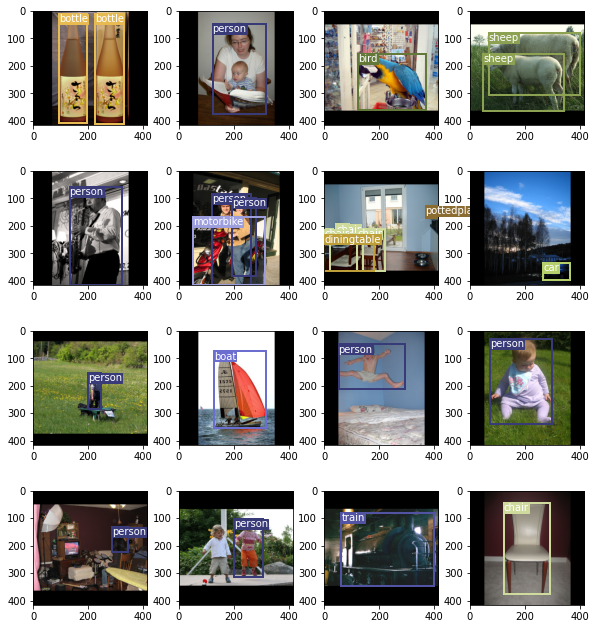

In [40]:
test_dataset = CustomDataset(ANNOTATIONS[:16], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
    
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=16)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)

for data, target in test_loader:
    bboxes = cells_to_boxes(target, False)
    plot_image(data, bboxes)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


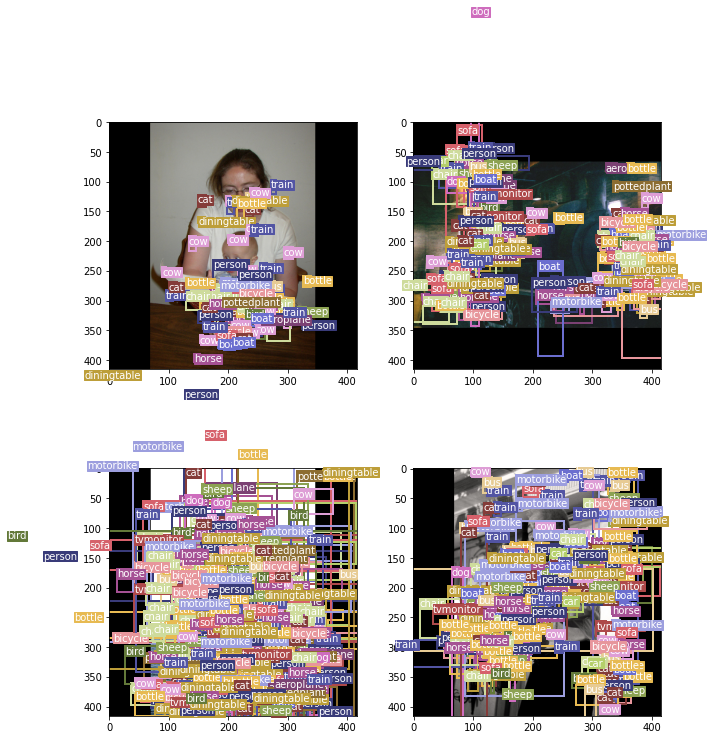

In [41]:
test_dataset = CustomDataset(ANNOTATIONS[:4], IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
    
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)

for data, target in test_loader:
    out = model(data.to(device))
    for i in range(len(out)):
        out[i] = out[i].to('cpu')
    data.to('cpu')
    bbox = cells_to_boxes(out, True)
    plot_image(data, bbox)

## Training the model

In [48]:
idx_train = int(len(ANNOTATIONS) * 0.70)
idx_test = int(len(ANNOTATIONS) * 0.85)
# train_ann = ANNOTATIONS[:idx_train] train for a bit on entire dataset before export
train_ann = ANNOTATIONS
val_ann = ANNOTATIONS[idx_train:idx_test]
test_ann = ANNOTATIONS[idx_test:]

In [55]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 150
test_dataset = CustomDataset(test_ann, IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

train_dataset = CustomDataset(train_ann, IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=train_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

val_dataset = CustomDataset(val_ann, IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = YOLOv3(3, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

start_epoch = 0
best_loss = None
load = True
if load:
    checkpoint = torch.load("drive/MyDrive/trained_models/YOLOv3/model.ph")
    start_epoch =  checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['loss']
    print(start_epoch, best_loss)

history = train(model, train_loader, val_loader, test_loader, optimizer, 
          Loss, ANCHORS, S, start_epoch, NUM_EPOCHS, best_loss, 'YOLOv3', device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


119 3.584196172145583


Test: 100%|██████████| 161/161 [00:48<00:00,  3.33it/s, loss=2.96]


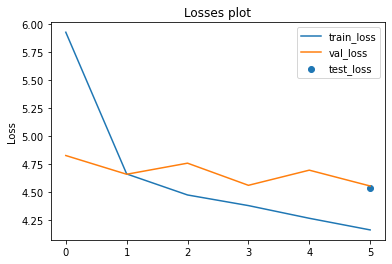

In [44]:
display_loss(history)

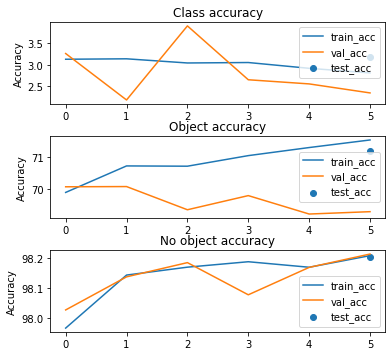

In [45]:
display_acc(history)

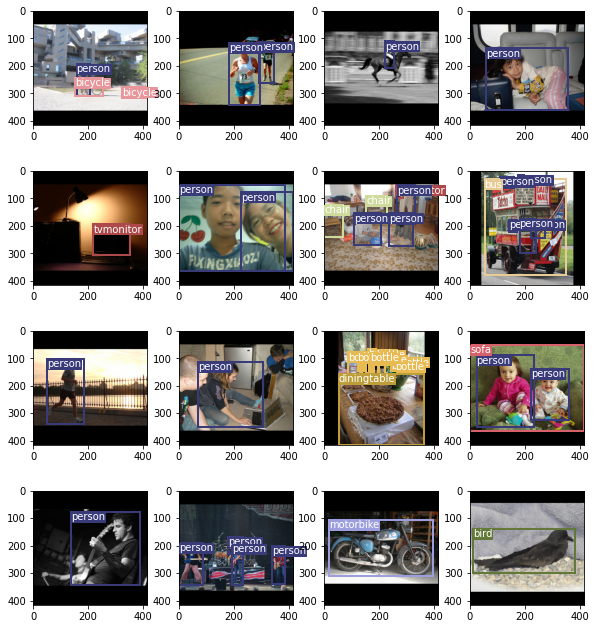

In [46]:
for data, target in test_loader:
    bboxes = cells_to_boxes(target, False)
    plot_image(data, bboxes)
    break

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


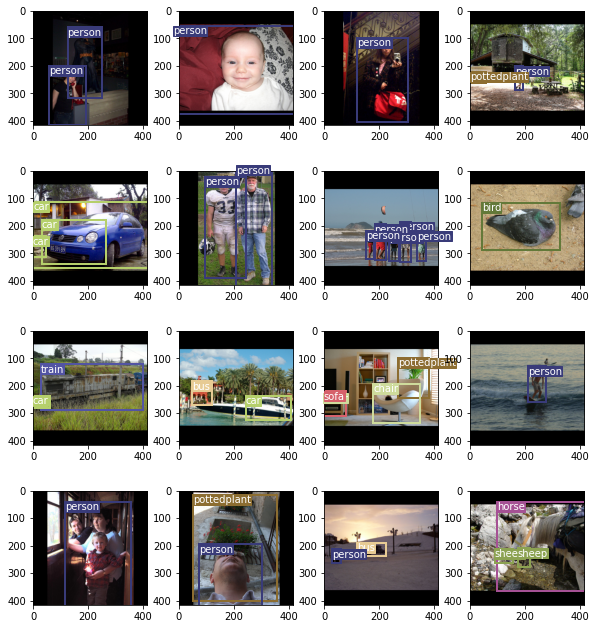

In [57]:
BATCH_SIZE = 16
test_dataset = CustomDataset(test_ann, IMAGE_DIR, LABEL_DIR,
                             ANCHORS, image_size=416,
                             S=[13, 26, 52], C=20,
                             transforms=test_transforms)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

model = YOLOv3(3, 20).to(device)

start_epoch = 0
best_loss = None
load = True
if load:
    checkpoint = torch.load("drive/MyDrive/trained_models/YOLOv3/model.ph")
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['loss']

for data, target in test_loader:
    out = model(data.to(device))
    for i in range(len(out)):
        out[i] = out[i].to('cpu')
    data.to('cpu')
    bbox = cells_to_boxes(out, True)
    plot_image(data, bbox)
    break

In [52]:
path = "drive/MyDrive/trained_models/YOLOv3/best.ph"

torch.save(model.state_dict(), path)